#APTOS 2019 Blindness Detection
#Detect diabetic retinopathy to stop blindness before it's too late

![image.png](https://th.bing.com/th/id/R.e6d60a41e4808c2da29f42c391e01fa3?rik=w3LWu2eY%2bwT%2fsg&riu=http%3a%2f%2fcceyemd.com%2fwp-content%2fuploads%2f2020%2f09%2f5_stages.png&ehk=%2bPM6xmk8fZX0hLZYLLXbzBy0mO8R1zXB0Kp3YdNpQrU%3d&risl=&pid=ImgRaw&r=0)

In this synchronous Kernels-only competition, you'll build a machine learning model to speed up disease detection. You’ll work with thousands of images collected in rural areas to help identify diabetic retinopathy automatically. If successful, you will not only help to prevent lifelong blindness, but these models may be used to detect other sorts of diseases in the future, like glaucoma and macular degeneration.

In this notebook, I will be using basic deep learning and transfer learning (ResNet50) to create a baseline.

In [1]:
! pip install -q kaggle


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"marinareda","key":"5b0c8dea157dc44264fc005991f565bb"}'}

In [3]:
from os import mkdir
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle competitions download -c aptos2019-blindness-detection


100% 9.51G/9.51G [06:24<00:00, 29.1MB/s]
100% 9.51G/9.51G [06:24<00:00, 26.6MB/s]


In [8]:
! unzip aptos2019-blindness-detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: test_images/512beaada8f0.png  
  inflating: test_images/51323e9d2070.png  
  inflating: test_images/515675001b9e.png  
  inflating: test_images/515877da2def.png  
  inflating: test_images/5168ddccea88.png  
  inflating: test_images/5172c056a687.png  
  inflating: test_images/5177461f5339.png  
  inflating: test_images/51910bcb980d.png  
  inflating: test_images/51a3e9b6a1c0.png  
  inflating: test_images/51bbd82feec8.png  
  inflating: test_images/51de5fb8eccd.png  
  inflating: test_images/51e88694c81f.png  
  inflating: test_images/51f0bf8f1544.png  
  inflating: test_images/51f57fb32840.png  
  inflating: test_images/51fa42dc1415.png  
  inflating: test_images/5276ab33b7b0.png  
  inflating: test_images/52a353760f72.png  
  inflating: test_images/531937254e73.png  
  inflating: test_images/5325b1c22c61.png  
  inflating: test_images/53959e0a750b.png  
  inflating: test_images/53be22c72713.png  
  inflating: test_images/

In [9]:
import cv2;
import matplotlib.pyplot as plt
import numpy as np;
import pandas as pd
from random import shuffle;
import cv2;
from random import shuffle;
from tqdm import tqdm;
import tensorflow;
from keras import layers;
from keras import Model;
from keras.optimizers import SGD;
from keras.callbacks import TensorBoard;
IMAGE_SIZE = 300;


In [10]:
! pip3 install keras

In [11]:
from keras.optimizers import Adam, SGD, RMSprop

In [12]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [13]:

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
train_Data_X_File = drive.CreateFile({'id': '1IJRvy-hV3sgEzjJVMnAtieeaASnjClZ1'});
train_Data_Y_File = drive.CreateFile({'id': '1_flYvBAJCp-vP0lYWkAEH3NgkS6Oqa9W'});

In [14]:
#This block takes 4-5 minutes to load the training data.
train_Data_X_File.GetContentFile('train_Data_X.npy');
train_Data_X = np.load('train_Data_X.npy', allow_pickle=True)

train_Data_Y_File.GetContentFile('train_Data_Y.npy');
train_Data_Y = np.load('train_Data_Y.npy', allow_pickle=True)

train_Data_X.shape

(3662, 1, 300, 300, 3)

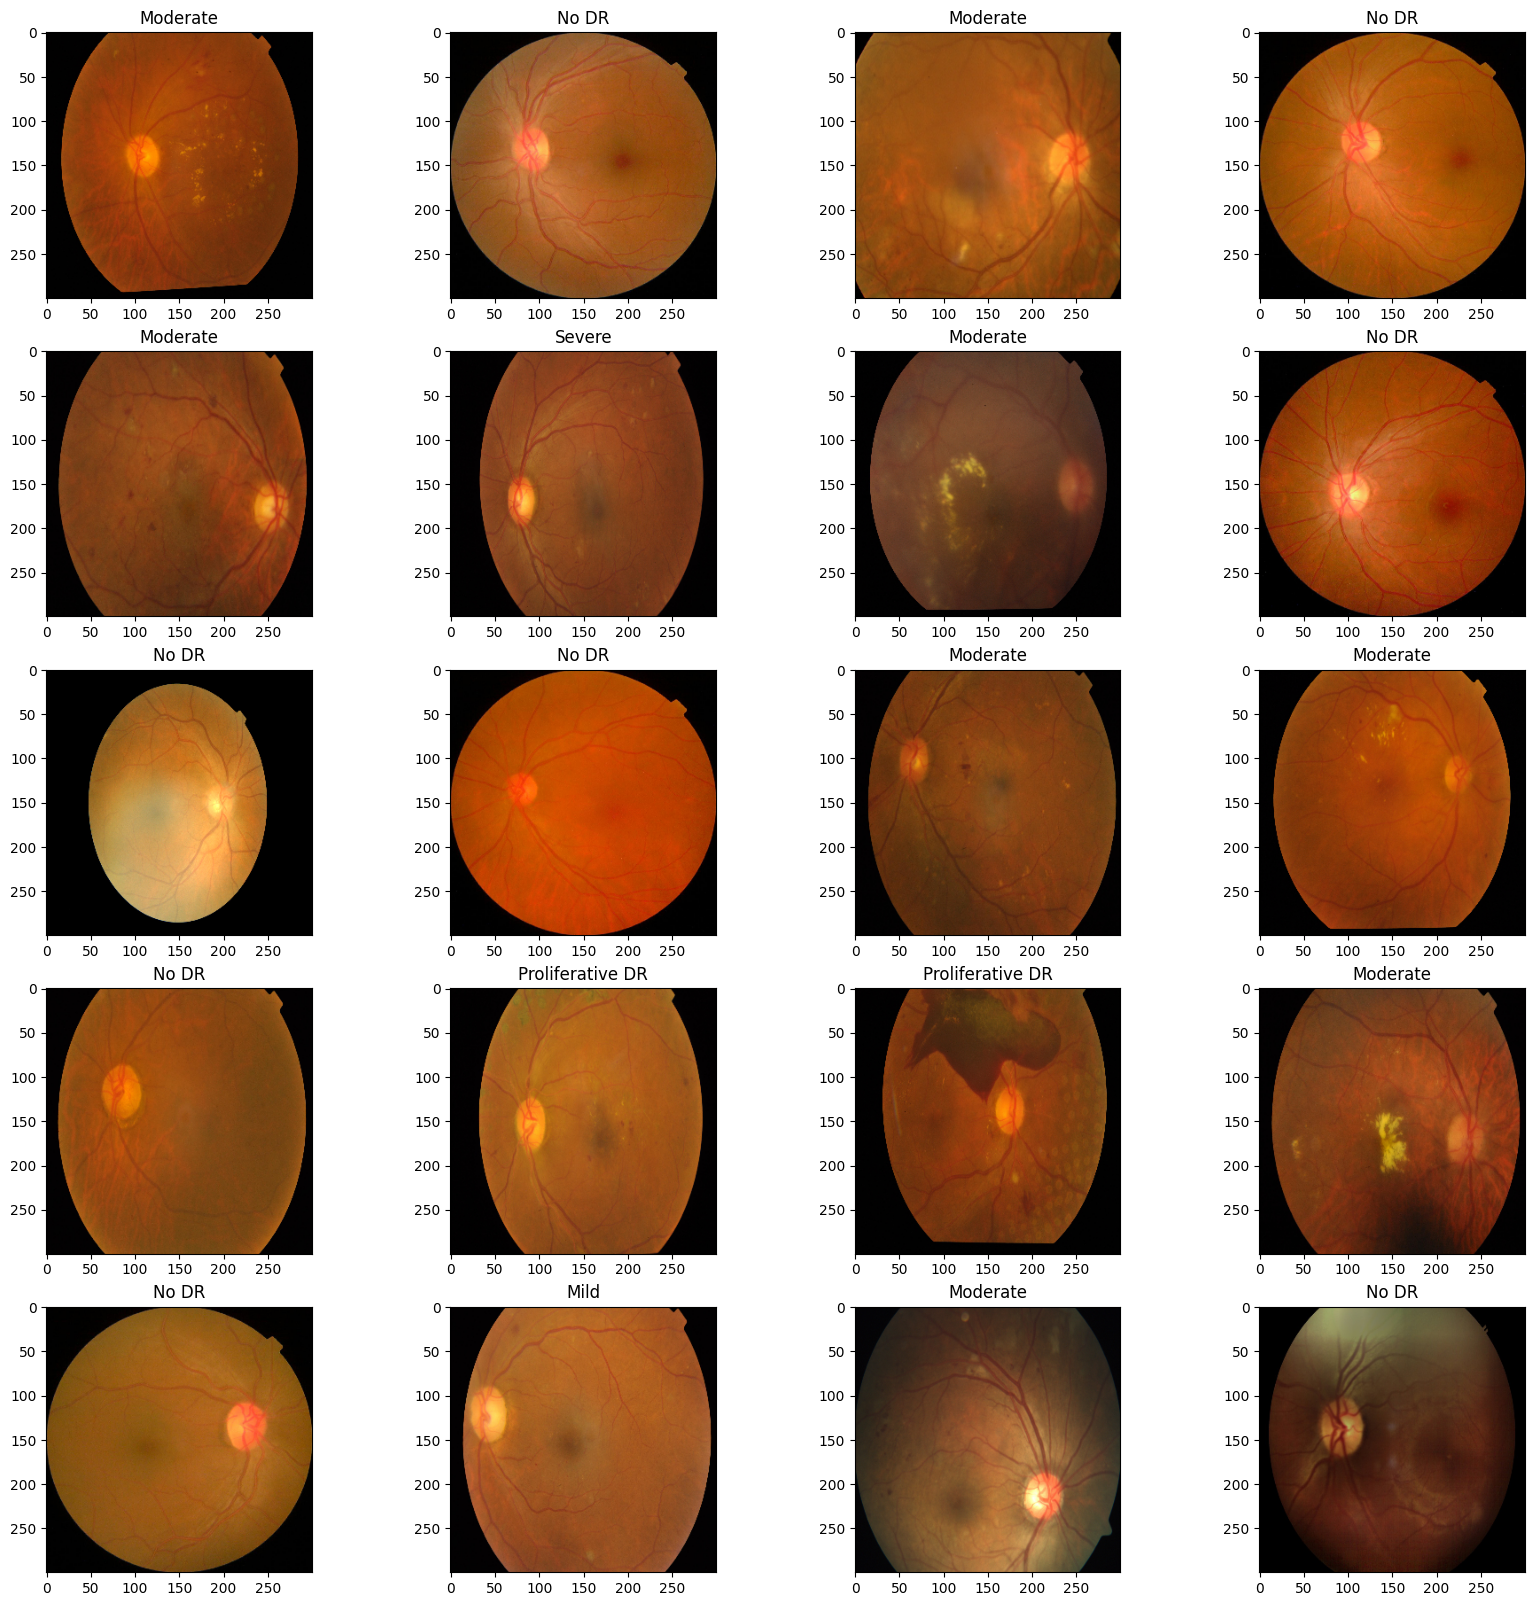

In [16]:
#Show some training images with labels
count = 0;
Num_of_Images = 20;
plt.figure(figsize=(20,20))
label = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR'];
for i in np.random.randint(1000, size = Num_of_Images):
  count = count+1;
  plt.subplot(Num_of_Images//4,4, count);
  plt.imshow(np.reshape(train_Data_X[i],(IMAGE_SIZE,IMAGE_SIZE,3)));
  plt.title(label[int(train_Data_Y[i])]);

In [17]:
#Splitting data into training and testing sets
num_of_Rows = train_Data_X.shape[0];
num_of_columns = train_Data_X.shape[1];
training_X = train_Data_X[:int(np.round(num_of_Rows*0.8))]   #80% data into training
testing_X = train_Data_X[int(np.round(num_of_Rows*0.8)):]     #20% data into testing
training_Y = train_Data_Y[:int(np.round(num_of_Rows*0.8))]   #80% data into training
testing_Y = train_Data_Y[int(np.round(num_of_Rows*0.8)):]     #20% data into testing


In [18]:
# Input images are of size 300x300x3 in which image pixels(300x300) and 3 for the three color channels: R, G, and B
img_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

In [19]:
# First convolution extracts 16 filters that are 3x3 Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

In [20]:
# Second convolution extracts 32 filters that are 3x3 Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

In [21]:
# Third convolution extracts 64 filters that are 3x3 Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

In [22]:
# Second convolution extracts 128 filters that are 3x3 Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(128, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

In [23]:
# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

In [24]:
# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

In [25]:
# Create output layer with a five nodes and softmax activation
output = layers.Dense(5, activation='softmax')(x)

In [26]:
# Create model:
model = Model(img_input, output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        18496 

In [27]:
#Compiling the model
model.compile(loss='sparse_categorical_crossentropy',optimizer=Adam(lr=0.00005),metrics=['acc']);

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [28]:
# Prepare the data for the training by separating X and Y vectors.
X_train = np.array([i[0] for i in tqdm(training_X)]);
Y_train = np.array([i[0] for i in training_Y]);

X_test = np.array([i[0] for i in tqdm(testing_X)]);
Y_test = np.array([i[0] for i in testing_Y]);

X_train.shape

100%|██████████| 732/732 [00:00<00:00, 450709.12it/s]


(2930, 300, 300, 3)

In [29]:
#Fitting training and testing dataset into model
Model_fit = model.fit(X_train,Y_train, batch_size =64, epochs = 10,verbose=1, validation_data=(X_test, Y_test))

Epoch 1/10
46/46 [==============================] - 361s 8s/step - loss: 4.8141 - acc: 0.5952 - val_loss: 0.9501 - val_acc: 0.6311
Epoch 2/10
46/46 [==============================] - 382s 8s/step - loss: 0.7970 - acc: 0.7119 - val_loss: 0.8121 - val_acc: 0.7309
Epoch 3/10
46/46 [==============================] - 372s 8s/step - loss: 0.7022 - acc: 0.7464 - val_loss: 0.7689 - val_acc: 0.7199
Epoch 4/10
46/46 [==============================] - 367s 8s/step - loss: 0.6229 - acc: 0.7683 - val_loss: 0.7592 - val_acc: 0.7363
Epoch 5/10
46/46 [==============================] - 377s 8s/step - loss: 0.5765 - acc: 0.7898 - val_loss: 0.7569 - val_acc: 0.7500
Epoch 6/10
46/46 [==============================] - 370s 8s/step - loss: 0.5442 - acc: 0.7945 - val_loss: 0.7794 - val_acc: 0.7104
Epoch 7/10
46/46 [==============================] - 382s 8s/step - loss: 0.4935 - acc: 0.8208 - val_loss: 0.7763 - val_acc: 0.7404
Epoch 8/10
46/46 [==============================] - 367s 8s/step - loss: 0.4533 - a

In [30]:
#Evaluating Test Loss And Test Accuracy
Marks=model.evaluate(X_test,Y_test,verbose=0)
print('Test Accuracy percentage:',100*Marks[1],"%")
print('Test Loss percentage:',100*Marks[0],"%")

Test Accuracy percentage: 74.59016442298889 %
Test Loss percentage: 76.98307633399963 %


In [31]:
import matplotlib.pyplot as plt

1/1 [==============================] - 0s 58ms/step


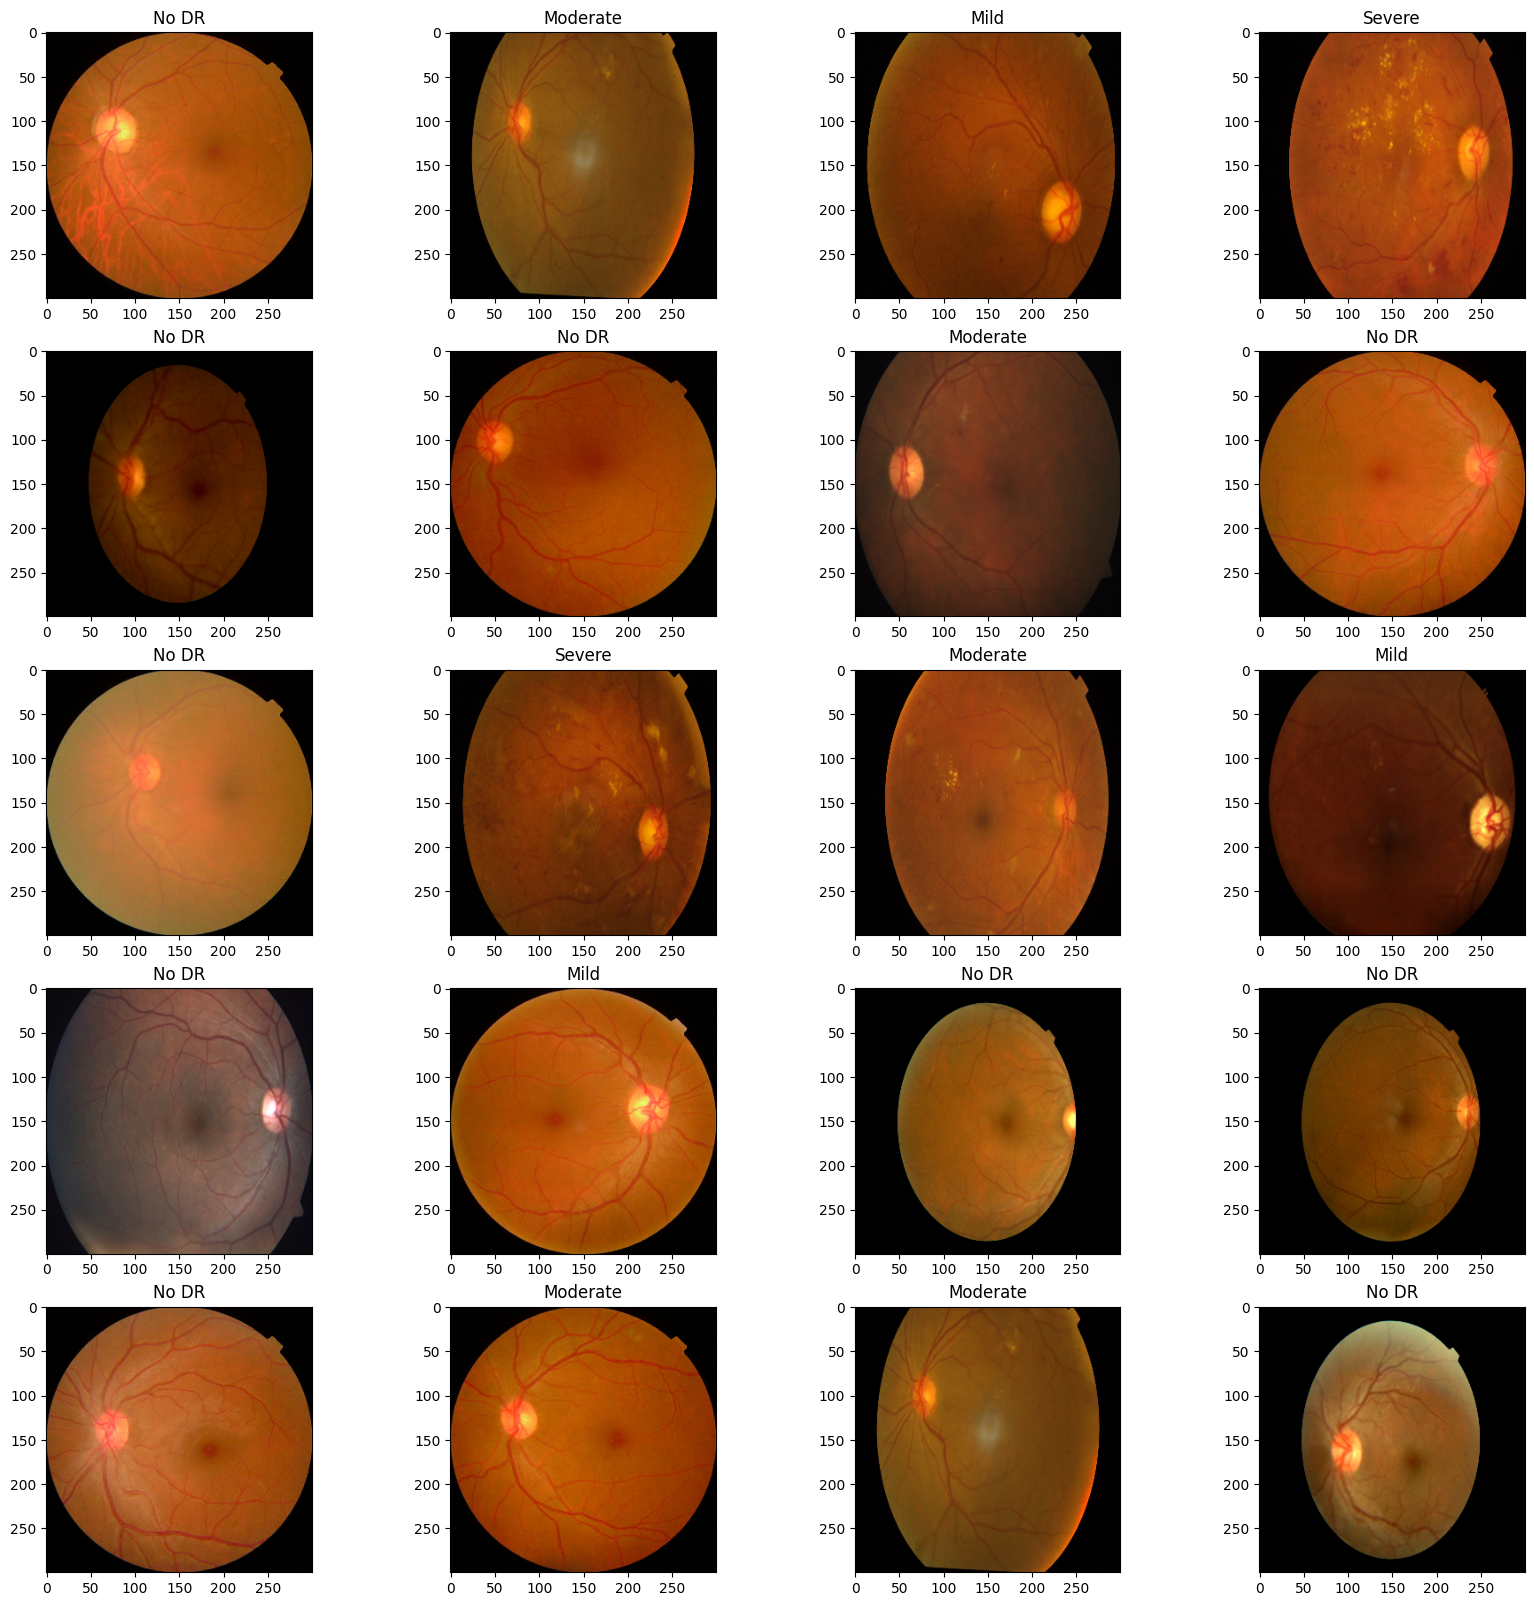

In [33]:
#Show some random test images with their prediction as title
count=0;
Num_of_Images=20;
plt.figure(figsize=(20,20))
label=['No DR','Mild','Moderate','Severe','Proliferative DR'];
for i in np.random.randint(500,size=Num_of_Images):
  count=count+1;
  plt.subplot(Num_of_Images//4,4, count);
  plt.imshow(np.reshape(X_test[i],(IMAGE_SIZE,IMAGE_SIZE,3)));
  P = model.predict(X_test[i].reshape(1,IMAGE_SIZE,IMAGE_SIZE,3)) # Prediction of testing images
  P=np.array(P);
  plt.title(label[int(Y_test[i])]);

In [34]:
#Evaluating accuracy,val_accuracy,loss,val,loss
acc=Model_fit.history['acc']
val_acc=Model_fit.history['val_acc']
loss=Model_fit.history['loss']
val_loss=Model_fit.history['val_loss']
epochs=range(1,len(acc)+1)

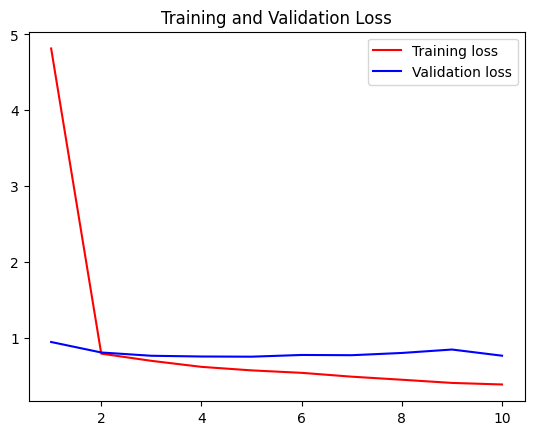

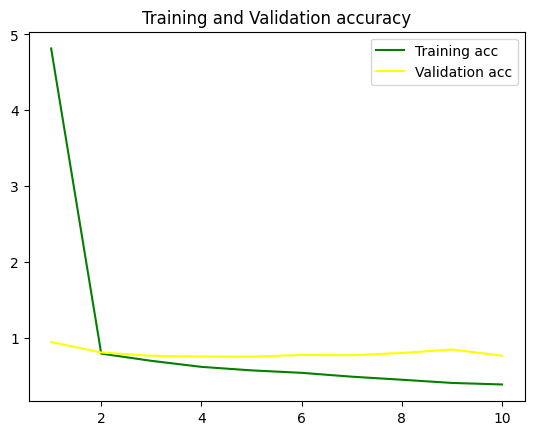

In [35]:
#Plotting Training and Validation loss
plt.figure()
plt.title('Training and Validation Loss')
plt.plot(epochs,loss,'red',label='Training loss')
plt.plot(epochs,val_loss,'blue',label='Validation loss')
plt.legend()

#Plotting Training and Validation accuracy
plt.figure()
plt.title('Training and Validation accuracy')
plt.plot(epochs,loss,'green',label='Training acc')
plt.plot(epochs,val_loss,'yellow',label='Validation acc')

plt.legend()
plt.show()

